In [1]:
from random_numbers import Bernoulli, Binomial, Cauchy, DiscretaGeneral, Erlang
from random_numbers import Exponencial, GammaAR, Geometrica, GLC, LogUniforme
from random_numbers import Normal, Poisson, Semicircular, UniformeAB, random

## 🎲 Generador lineal congruencial (GLC)

El **generador lineal congruencial** es uno de los métodos más clásicos para producir números pseudoaleatorios.

### 📌 Definición

La sucesión se define mediante la recurrencia

$$
x_{n+1} = \mathrm{glc}(x_n) = a(x_n + c) \; \text{mod} \; m,
$$

y los números pseudoaleatorios normalizados se obtienen como

$$
u_n = \mathrm{gglc}(x_n) = \frac{x_n}{m}.
$$

donde:

- $a$ : multiplicador,
- $c$ : incremento,
- $m$ : módulo,
- $x_0$ : semilla inicial.

---

### ⚙️ Parámetros de Park y Miller (1988)

Park y Miller sugirieron la siguiente elección de parámetros:

$$
m = 2^{31} - 1, \qquad a = 7^5, \qquad c = 0.
$$

Este caso particular se conoce como el **minimal standard generator** y es ampliamente usado como referencia histórica en simulación.


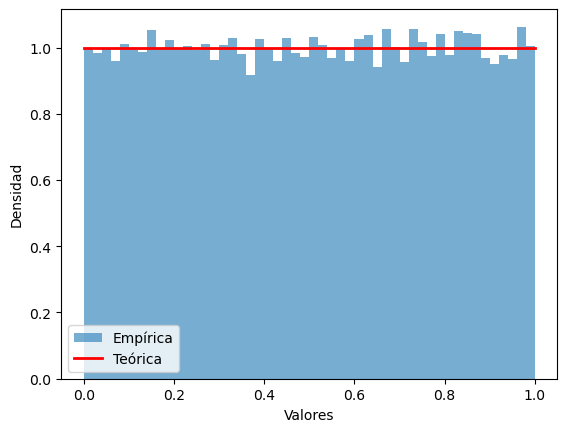

In [2]:
glc = GLC(seed=16230)
glc.plot(50000)

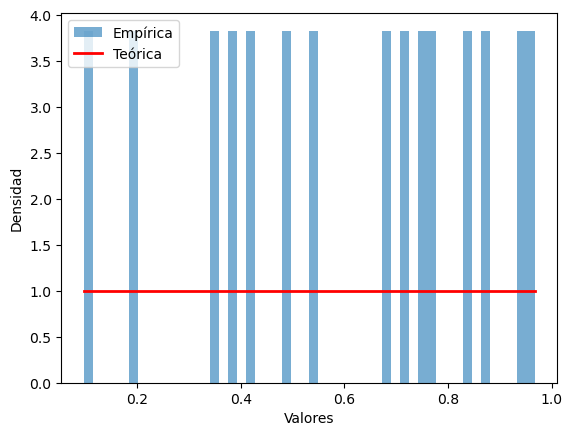

In [3]:
glc2 = GLC(seed=15672,a=2**3-1,c=0,m=2**5-1)
glc2.plot(10000)

In [4]:
# Generar números uniformes
random.seed(23)

for _ in range(10):
    print(random.random())

0.9248652516259452
0.9486057779931771
0.8924333440485793
0.08355067683068362
0.5920272268857353
0.4237474082349614
0.5300880101180064
0.13030294124748054
0.1919971575392927
0.444573573873013


# Transformada Inversa

## 🎲 Simulación usando $U \sim \mathrm{Uniforme}(0,1)$

### 🔹 Caso Bernoulli($p$)

Si tenemos acceso a una variable aleatoria $U \sim \mathrm{Uniforme}(0,1)$, 
podemos simular una variable

$$
X \sim \mathrm{Bernoulli}(p), \qquad 0 < p < 1,
$$

definiendo

$$
X = \mathbf{1}_{\{U \le p\}}.
$$

En efecto,

- $P(X=1) = P(U \le p) = p$,
- $P(X=0) = 1 - p$,

por lo que $X$ tiene distribución Bernoulli$(p)$.

---

### 🔹 Caso discreto general

Sea $X$ una variable aleatoria discreta que toma valores en

$$
\{x_1, x_2, \dots, x_n\},
$$

con probabilidades

$$
P[X = x_i] = p_i, \qquad i=1,\dots,n,
$$

donde

$$
\sum_{i=1}^{n} p_i = 1.
$$

Para simular $X$ usando $U \sim \mathrm{Uniforme}(0,1)$, definimos:

$$
X =
\begin{cases}
x_1, & \text{si } 0 < U \le p_1, \\
x_2, & \text{si } p_1 < U \le p_1 + p_2, \\
\vdots \\
x_n, & \text{si } p_1 + \cdots + p_{n-1} < U \le 1.
\end{cases}
$$

Este procedimiento se basa en dividir el intervalo $(0,1)$ según las
probabilidades acumuladas y asignar cada subintervalo a un valor posible de $X$.


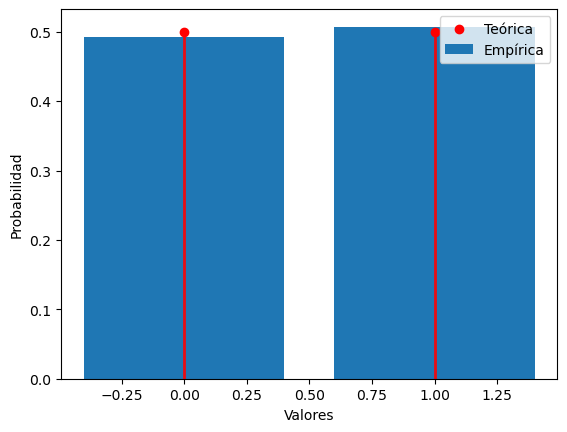

In [5]:
bern = Bernoulli(0.5)
bern.plot(5000)

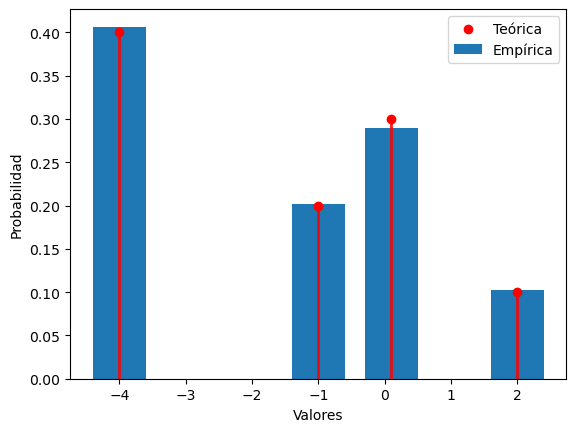

In [6]:
valores = [-1,0.1,2.0,-4]
probs = [0.2, 0.3, 0.1, 0.4]

dg = DiscretaGeneral(valores, probs)
dg.plot(5000)


## 🎲 Simulación de una uniforme $(a,b)$ usando $U \sim \mathrm{Uniforme}(0,1)$

Sea $X \sim \mathrm{Uniforme}(0,1)$.  
Podemos construir una variable aleatoria

$$
Y = (b-a)X + a,
$$

donde $a < b$, y entonces

$$
Y \sim \mathrm{Uniforme}(a,b).
$$

### 📌 Idea

La transformación

$$
T(x) = (b-a)x + a
$$

es una transformación lineal que:

- escala el intervalo $(0,1)$ a longitud $(b-a)$,
- y lo traslada para que comience en $a$.

En efecto,

- si $X \in (0,1)$ entonces $Y \in (a,b)$,
- y la densidad resultante es constante en $(a,b)$.

### 🔹 Procedimiento de simulación

1. Generar $X \sim \mathrm{Uniforme}(0,1)$.
2. Definir
   $$
   Y = (b-a)X + a.
   $$
3. El valor obtenido tiene distribución $\mathrm{Uniforme}(a,b)$.


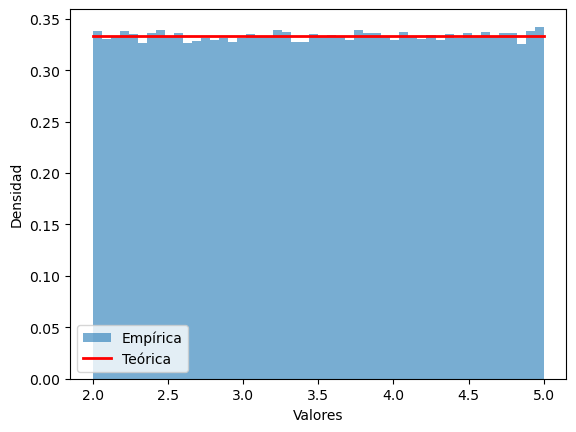

In [7]:
u = UniformeAB(2, 5)
u.plot(500000)

## 🎲 Simulación de una variable aleatoria Cauchy usando variables Uniformes

La distribución **Cauchy estándar** tiene densidad

$$
f(x)=\frac{1}{\pi(1+x^2)}, \qquad x \in \mathbb{R}.
$$

Existen dos transformaciones clásicas para simular una variable
$$
X \sim \mathrm{Cauchy}(0,1)
$$
a partir de variables Uniformes.

---

## 🔹 1. Usando $\Theta \sim \mathrm{Uniforme}(0,2\pi)$

Sea

$$
\Theta \sim \mathrm{Uniforme}(0,2\pi).
$$

Definimos la transformación

$$
X = \tan\!\left(\frac{\Theta}{2}\right).
$$

Entonces

$$
X \sim \mathrm{Cauchy}(0,1).
$$

### 📌 Idea

La transformación

$$
x = \tan(\theta/2)
$$

convierte un ángulo uniforme sobre el círculo en una variable real con
colas pesadas. El jacobiano del cambio de variable produce el factor
$(1+x^2)^{-1}$ característico de la densidad Cauchy.

Geométricamente:

- se toma un ángulo uniforme,
- se proyecta mediante la tangente,
- se obtiene una distribución Cauchy en la recta real.

---

## 🔹 2. Usando $U \sim \mathrm{Uniforme}(0,1)$ (transformada inversa)

Otra forma equivalente parte de

$$
U \sim \mathrm{Uniforme}(0,1).
$$

Definimos

$$
X = \tan\!\big(\pi(U - \tfrac12)\big).
$$

Entonces

$$
X \sim \mathrm{Cauchy}(0,1).
$$

### 📌 Justificación

La función de distribución acumulada (CDF) de la Cauchy estándar es

$$
F(x)=\frac12+\frac{1}{\pi}\arctan(x).
$$

Aplicando el método de la transformada inversa:

$$
U = F(X)
\quad \Rightarrow \quad
X = \tan\!\big(\pi(U-\tfrac12)\big).
$$

---

## ⭐ Observación

Ambas construcciones son equivalentes:

- $\Theta = 2\pi U$ con $U\sim U(0,1)$,
- sustituyendo en $X=\tan(\Theta/2)$ se obtiene
  $$
  X=\tan(\pi U).
  $$
- desplazando $U$ en $1/2$ se obtiene la forma simétrica más usada:
  $$
  X=\tan\!\big(\pi(U-\tfrac12)\big).
  $$

Esta segunda expresión suele preferirse en simulación numérica porque es
más directa y evita trabajar explícitamente con ángulos en $(0,2\pi)$.


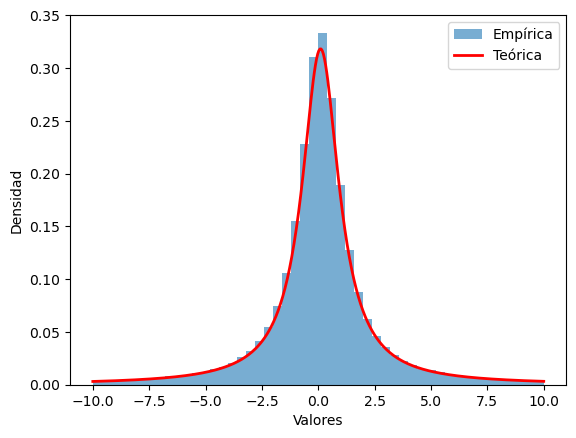

In [8]:
c = Cauchy(0.1)
c.plot(500000,rango=(-10,10))

## 🎲 Simulación de una variable Exponencial usando $U \sim \mathrm{Uniforme}(0,1)$

Sea $X$ una variable aleatoria con distribución exponencial de parámetro
$\lambda > 0$, cuya densidad es

$$
f(x)=\lambda e^{-\lambda x}, \qquad x \ge 0.
$$

---

## 🔹 Método de la transformada inversa

La función de distribución acumulada (CDF) de la exponencial es

$$
F(x)=1-e^{-\lambda x}.
$$

Si $U \sim \mathrm{Uniforme}(0,1)$, entonces por el método de la
transformada inversa:

$$
U = F(X) = 1 - e^{-\lambda X}.
$$

Despejando $X$:

$$
X = -\frac{1}{\lambda}\ln(1-U).
$$

Por lo tanto, si definimos

$$
X = -\frac{1}{\lambda}\ln(1-U),
$$

entonces

$$
X \sim \mathrm{Exponencial}(\lambda).
$$

---

## ⭐ Forma equivalente

Como $1-U \sim \mathrm{Uniforme}(0,1)$, también puede usarse

$$
X = -\frac{1}{\lambda}\ln(U),
$$

que es la forma más común en simulación computacional.


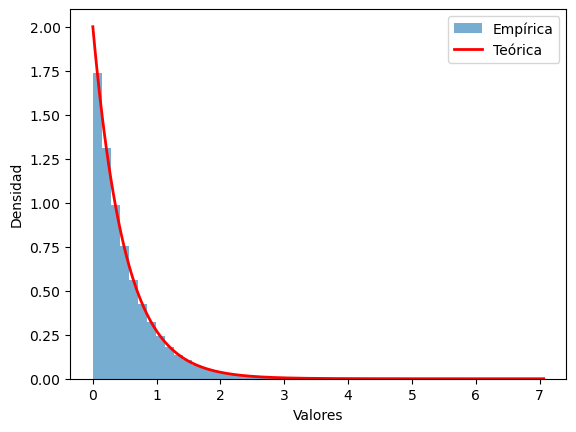

In [9]:
exp = Exponencial(lambd=2)

exp.plot(500000)

## 🎲 Simulación Erlang usando el producto de uniformes

Sea $X \sim \mathrm{Erlang}(k,\lambda)$ con $k \in \mathbb{N}$ y $\lambda>0$.

Si $U_1,\dots,U_k \sim \mathrm{Uniforme}(0,1)$ independientes, entonces

$$
X = -\frac{1}{\lambda}\ln\!\Big(\prod_{i=1}^{k} U_i\Big)
$$

sigue una distribución $\mathrm{Erlang}(k,\lambda)$.

### 📌 Idea

Sabemos que una exponencial puede generarse como

$$
E_i = -\frac{1}{\lambda}\ln(U_i).
$$

Entonces

$$
X=\sum_{i=1}^k E_i
= -\frac{1}{\lambda}\sum_{i=1}^k \ln(U_i)
= -\frac{1}{\lambda}\ln\!\Big(\prod_{i=1}^k U_i\Big).
$$

Esta forma es algebraicamente equivalente pero suele ser más compacta
y eficiente en implementación.


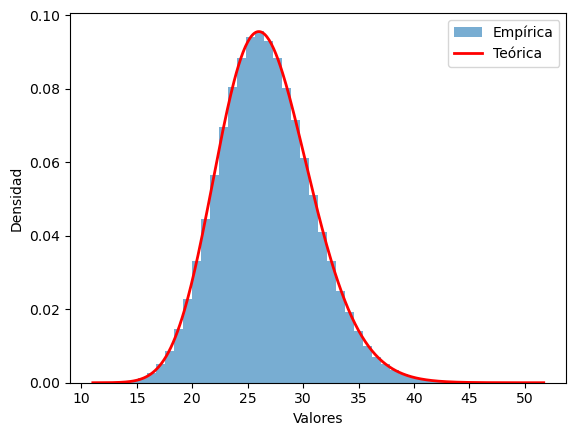

In [11]:
Er = Erlang(40, 1.5)
Er.plot(500000)

## 🎲 Simulación de una Binomial como suma de Bernoulli

La distribución **Binomial** puede construirse de forma natural a partir de variables Bernoulli, lo que permite simularla fácilmente usando únicamente variables Uniforme$(0,1)$.

---

### 📌 Idea básica

Recordemos que si

$$
X \sim \text{Bernoulli}(p),
$$

entonces puede generarse usando una uniforme

$$
U \sim \text{Uniforme}(0,1)
$$

mediante

$$
X = \mathbf{1}\{U \le p\}.
$$

---

### 🔁 Construcción de la Binomial

Sea

$$
X_1, X_2, \dots, X_n \sim \text{Bernoulli}(p) \quad \text{iid}.
$$

Entonces la suma

$$
S_n = X_1 + X_2 + \cdots + X_n
$$

sigue una distribución

$$
S_n \sim \text{Binomial}(n,p).
$$

---

### ⚙️ Algoritmo de simulación

Para generar una realización de $Y \sim \text{Binomial}(n,p)$:

1. Generar $U_1,\dots,U_n \sim \text{Uniforme}(0,1)$.
2. Definir

$$
X_i =
\begin{cases}
1, & U_i \le p, \\
0, & U_i > p.
\end{cases}
$$

3. Calcular

$$
Y = \sum_{i=1}^{n} X_i.
$$

---

### 🧠 Interpretación

La distribución binomial puede verse como el número de éxitos en $n$ ensayos independientes, donde cada ensayo se obtiene transformando una uniforme mediante una función indicadora. Esto muestra nuevamente cómo muchas distribuciones discretas pueden construirse a partir de Uniformes$(0,1)$.


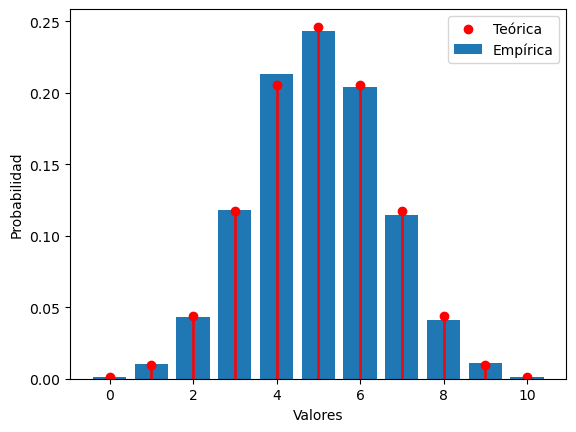

In [12]:
Bin = Binomial(10, 0.5)
Bin.plot(10000)

## 🎯 Simulación de la distribución Geométrica usando Transformada Inversa

Sea

$$
X \sim \text{Geom}(p),
$$

con función de probabilidad

$$
P(X=k) = (1-p)^{k-1}p, \quad k=1,2,3,\dots
$$

Esta variable representa el número de ensayos necesarios hasta obtener el primer éxito.

---

### 📌 Función de distribución acumulada

La CDF es

$$
F(k)=P(X\le k)=1-(1-p)^k.
$$

---

### 🧠 Método de la transformada inversa

Sea

$$
U \sim \text{Uniforme}(0,1).
$$

La inversa generalizada se define como

$$
X = \min \{k \in \mathbb{N} : F(k) \ge U \}.
$$

Entonces:

$$
1-(1-p)^k \ge U
$$

$$
(1-p)^k \le 1-U
$$

Tomando logaritmos:

$$
k \ge \frac{\log(1-U)}{\log(1-p)}.
$$

Por lo tanto,

$$
X =
\left\lceil
\frac{\log(1-U)}{\log(1-p)}
\right\rceil.
$$

Como $1-U$ también es uniforme, una forma equivalente es

$$
X =
\left\lfloor
\frac{\log(U)}{\log(1-p)}
\right\rfloor + 1.
$$

---

### ⚙️ Algoritmo

1. Generar $U \sim \text{Uniforme}(0,1)$.
2. Calcular

$$
X =
\left\lfloor
\frac{\log(U)}{\log(1-p)}
\right\rfloor + 1.
$$

Entonces $X \sim \text{Geom}(p)$.

---

### ⭐ Observaciones

- Método exacto.
- Muy eficiente (una sola uniforme).
- Mucho más rápido que repetir Bernoullis hasta éxito.


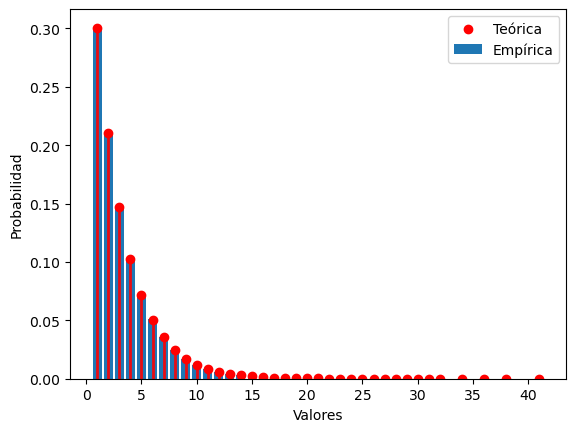

In [13]:
g = Geometrica(0.3)
g.plot(500000)

## 🎯 Simulación de una variable con densidad  $$ f(x)=\frac{1}{x}$$  en $[1,e]$

Queremos simular una variable aleatoria continua cuya densidad es

$$
f(x)=\frac{1}{x}, \quad 1 \le x \le e.
$$

---

### 📌 Verificación de que es una densidad válida

Comprobamos que integra 1:

$$
\int_1^e \frac{1}{x}\,dx
=
\ln(e) - \ln(1)
=
1.
$$

✔ Está correctamente normalizada.

---

### 🧠 Método: Transformada Inversa

Para usar el método de transformación inversa necesitamos la función de distribución acumulada (CDF).

---

$ $e la CDF

Para \(1 \le x \le e\),

$$
F(x)
=
\int_1^x \frac{1}{t}\,dt
=
\ln(x).
$$

---

### 2️⃣ Igualamos a una uniforme

Sea

$$
U \sim \text{Uniforme}(0,1).
$$

Igualamos:

$$
U = F(x) = \ln(x).
$$

Despejamos \(x\):

$$
x = e^{U}.
$$

---

### ✨ Resultado final

Si

$$
U \sim \text{Uniforme}(0,1),
$$

entonces

$$
X = e^{U}
$$

tiene densidad

$$
f(x)=\frac{1}{x}, \quad 1 \le x \le e.
$$

---

### 🧠 Interpretación

Esta variable puede verse como una **Uniforme en escala logarítmica**, ya que

$$
\ln(X) \sim \text{Uniforme}(0,1).
$$

Es uno de los ejemplos más limpios y elegantes del método de transformación inversa.
0,1).
$$

Es uno de los ejemplos más limpios y elegantes del método de transformación inversa.
bablemente una de las simulaciones más limpias que existen.


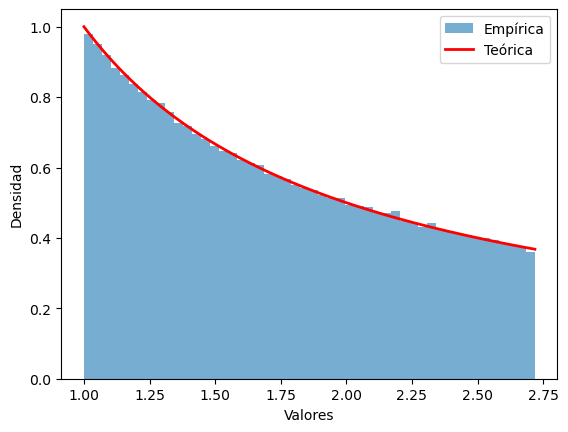

In [15]:
x = LogUniforme()
x.plot(500000)

## 🎯 Simulación de la distribución Normal usando el método de Box–Muller

Queremos generar una variable aleatoria

$$
X \sim \mathcal{N}(\mu,\sigma^2).
$$

La estrategia consiste en generar primero una normal estándar

$$
Z \sim \mathcal{N}(0,1)
$$

y luego transformar mediante

$$
X = \mu + \sigma Z.
$$

---

### 🧠 Método de Box–Muller

Sea

$$
U_1, U_2 \sim \text{Uniforme}(0,1)
$$

independientes. Entonces las variables

$$
Z_1 =
\sqrt{-2\log(U_1)}\cos(2\pi U_2),
$$

$$
Z_2 =
\sqrt{-2\log(U_1)}\sin(2\pi U_2)
$$

son independientes y siguen una distribución

$$
\mathcal{N}(0,1).
$$

Por lo tanto, una normal general se obtiene como

$$
X = \mu + \sigma Z_1.
$$

---

### ⚙️ Algoritmo de simulación

1. Generar $U_1, U_2 \sim \text{Uniforme}(0,1)$ independientes.
2. Calcular

$$
Z =
\sqrt{-2\log(U_1)}\cos(2\pi U_2).
$$

3. Transformar

$$
X = \mu + \sigma Z.
$$

---

### 🧠 Interpretación geométrica

El método proviene de expresar la distribución normal bivariada en coordenadas polares.  
La variable radial tiene densidad proporcional a

$$
r e^{-r^2/2},
$$

lo que permite obtener una transformación exacta desde variables uniformes.

---

### ⭐ Observaciones

- El método genera **dos normales independientes** por iteración.
- Es exacto (no aproximado).
- Es uno de los algoritmos clásicos más utilizados en simulación.

---

### 🚀 Caso especial: Normal estándar

Cuando $\mu=0$ y $\sigma=1$:

$$
Z =
\sqrt{-2\log(U_1)}\cos(2\pi U_2).
$$

---


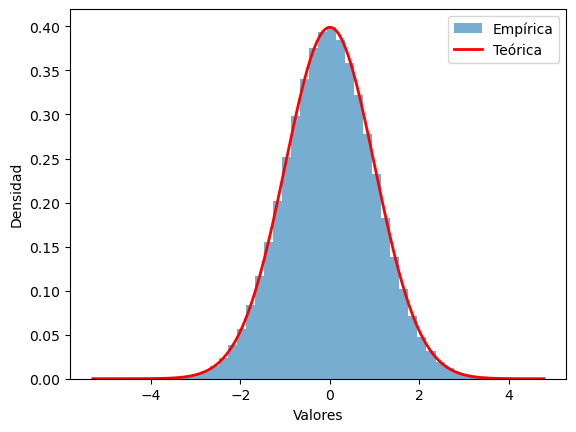

In [16]:
n = Normal(0, 1)
n.plot(500000)

## Simulación de una Variable Poisson usando Tiempos Exponenciales

Una forma muy elegante de simular una variable aleatoria Poisson consiste en usar la relación entre:

- El **proceso de Poisson**
- Los **tiempos entre llegadas exponenciales*#*

## Idea teórica

Sea un proceso de Poisson con tasa $ \lambda > 0 $.

Se sabe que:

- Los tiempos entre eventos consecutivos son variables independientes

$$
E_1, E_2, E_3, \dots \sim \text{Exp}(\lambda)
$$

- El tiempo del evento número $ n $ es

$$
T_n = E_1 + E_2 + \cdots + E_n
$$

Entonces, el número de eventos que ocurren en el intervalo $[0,1]$ es

$$
N = \max \{ n : T_n \le 1 \}
$$

y se cumple

$$
N \sim \text{Poisson}(\lambda)
$$

Por lo tanto, para simular una Poisson basta generar tiempos exponenciales, acumularlos y contar cuántos evento#s ocurren antes de tiempo 1.

---

## Interpretación intuitiva

Estamos simulando literalmente un **proceso de eventos en el tiempo**:

- Cada exponencial es el tiempo hasta el siguiente evento
- Contamos cuántos eventos caben en una ventana de longitud 1

Eso pr#oduce exactamente una variable Poisson.

---

## Comentarios importantes

✅ Este método es exacto  
✅ Tiene interpretación probabilística clara  
✅ Funciona muy bien cuando $ \lambda $ es moderado  

Sin embargo:

-. i $ \lambda $ es grande → puede ser lento (muchos eventos)

En ese caso existen otros métodos más eficientes.

---
)

En ese caso existen otros métodos más eficientes.

---

E = -\frac{1}{\lambda}\log(U)
$$

sigue una distribución exponencial con tasa $\lambda$.


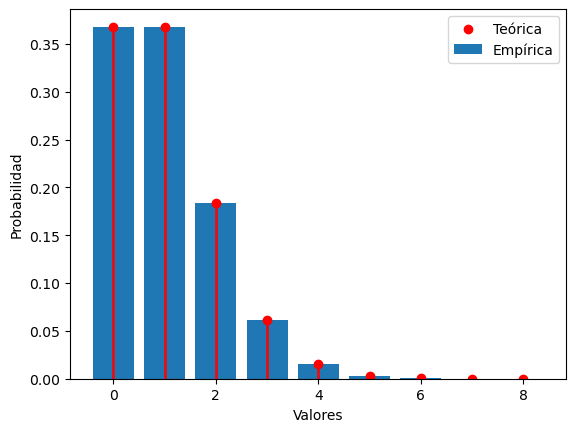

In [17]:
poi = Poisson(1)
poi.plot(500000)

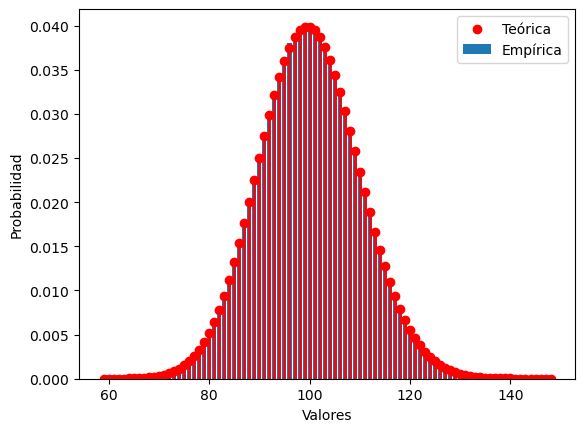

In [18]:
poi2 = Poisson(100)
poi2.plot(500000)

## 🎯 Simulación por Aceptación–Rechazo  
### Densidad semicircular $ \sqrt{1-x^2} $ en $[-1,1]$

Queremos generar una variable aleatoria con densidad

$$
f(x)=\sqrt{1-x^2}, \qquad -1\le x \le 1.
$$

Primero verificamos la constante de normalización:

$$
\int_{-1}^{1}\sqrt{1-x^2}\,dx
=
\frac{\pi}{2}.
$$

Por lo tanto, la densidad normalizada es

$$
f(x)=\frac{2}{\pi}\sqrt{1-x^2}.
$$

Esta es la **distribución semicircular**.

---

## 🧠 Método de Aceptación y Rechazo

Elegimos como distribución propuesta:

$$
g(x)=\text{Uniforme}(-1,1),
$$

porque es fácil de simular.

Sabemos que

$$
g(x)=\frac{1}{2}.
$$

Buscamos una constante $M$ tal que

$$
f(x)\le M g(x).
$$

El máximo de $f(x)$ ocurre en $x=0$:

$$
f(0)=\frac{2}{\pi}.
$$

Entonces:

$$
M=\frac{4}{\pi}.
$$

---

## ⚙️ Regla de aceptación

Si $X\sim \text{Uniforme}(-1,1)$ y $U\sim \text{Uniforme}(0,1)$,

aceptamos $X$ si

$$
U \le \sqrt{1-X^2}.
$$


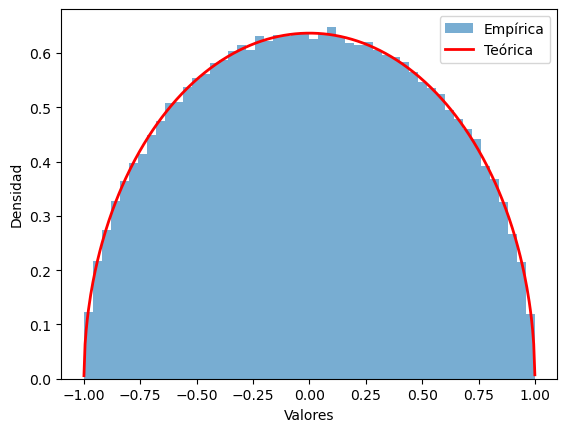

T_AR: 0.7854
E_AR: 0.7853


In [19]:
sc = Semicircular()
n = 500000
sc.plot(n)
r = len(sc.rejected)
E_ar = n/(n+r)
print('T_AR: {:.4f}'.format(sc.T_ar))
print('E_AR: {:.4f}'.format(E_ar))

# Simulación Gamma con Método de Aceptación y Rechazo

Queremos simular una variable aleatoria con densidad Gamma:

$$
p(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x}, 
\qquad x \ge 0,
$$

con parámetros:

- Forma: $\alpha \ge 1$
- Tasa: $\beta > 0$

---

## Idea del método

Se usa como envolvente otra distribución Gamma:

$$
q(x) \propto x^{\alpha_p - 1} e^{-\beta_p x},
$$

donde:

$$
\alpha_p = \lfloor \alpha \rfloor
$$

es la parte entera de $\alpha$.

Los parámetros se eligen para que:

- La envolvente tenga el mismo máximo que la densidad objetivo
- Se cumpla:

$$
p(x) \le K_p \, q(x)
$$

para todo $x \ge 0$.

---

## Parámetros

### Caso $\alpha \ge 2$

$$
\beta_p = \beta \frac{\alpha_p - 1}{\alpha - 1}
$$

$$
K_p = \exp(\alpha_p - \alpha)
\left(\frac{\alpha - 1}{\beta}\right)^{\alpha - \alpha_p}
$$

---

### Caso $1 \le \alpha < 2$

$$
\alpha_p = 1
$$

$$
\beta_p = \frac{\beta}{\alpha}
$$

$$
K_p =
\exp(1-\alpha)
\left(\frac{\alpha}{\beta}\right)^{\alpha-1}
$$

---

## Algoritmo

1. Calcular $\alpha_p$, $\beta_p$, $K_p$
2. Generar:

$$
X \sim \text{Gamma}(\alpha_p, \beta_p)
$$

3. Aceptar con probabilidad:

$$
\frac{p(X)}{K_p q(X)}
$$

4. Repetir hasta aceptar

---

Este método es eficiente porque:

- La Gamma propuesta se puede simular directamente
- La tasa de aceptación es alta cuando $\alpha$ es grande

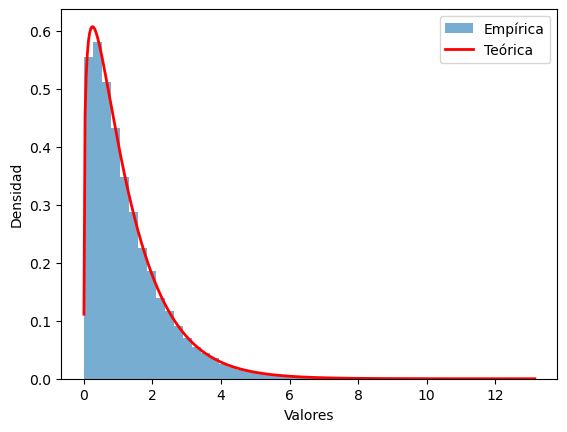

AR: 0.8804


In [20]:
gam_ar = GammaAR(1.25,1)
n = 100000
gam_ar.plot(n)
r = len(gam_ar.rejected)
E_ar = n/(n+r)
print('AR: {:.4f}'.format(E_ar))

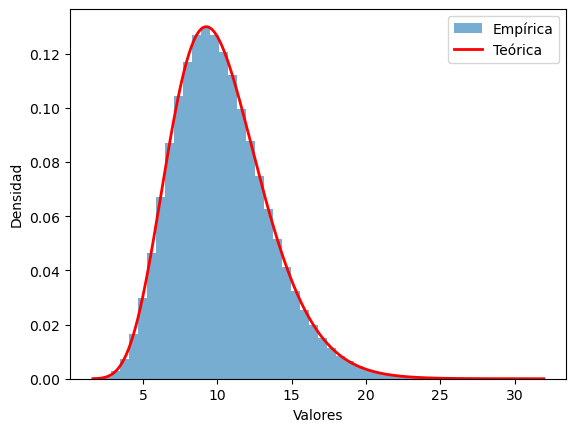

AR: 0.9860


In [21]:
gam_ar = GammaAR(10.25,1)
n = 500000
gam_ar.plot(n)
r = len(gam_ar.rejected)
E_ar = n/(n+r)
print('AR: {:.4f}'.format(E_ar))

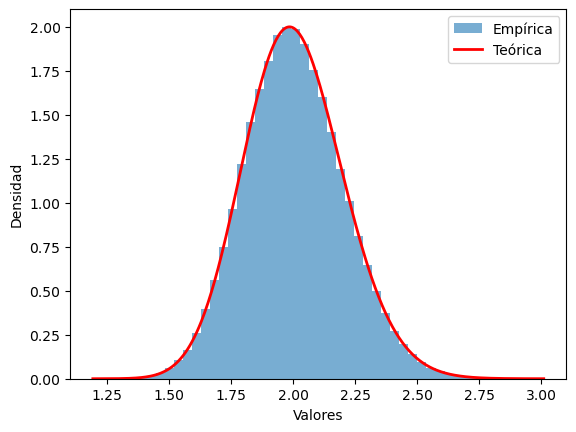

AR: 0.9987


In [22]:
gam_ar = GammaAR(100.25,50)
n = 500000
gam_ar.plot(n)
r = len(gam_ar.rejected)
E_ar = n/(n+r)
print('AR: {:.4f}'.format(E_ar))

## Simulando con numpy

In [23]:
import numpy.random as numprand

In [24]:
numprand.binomial(n=3,p=0.1,size=10)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [25]:
numprand.exponential?

Docstring:
exponential(scale=1.0, size=None)

Draw samples from an exponential distribution.

Its probability density function is

.. math:: f(x; \frac{1}{\beta}) = \frac{1}{\beta} \exp(-\frac{x}{\beta}),

for ``x > 0`` and 0 elsewhere. :math:`\beta` is the scale parameter,
which is the inverse of the rate parameter :math:`\lambda = 1/\beta`.
The rate parameter is an alternative, widely used parameterization
of the exponential distribution [3]_.

The exponential distribution is a continuous analogue of the
geometric distribution.  It describes many common situations, such as
the size of raindrops measured over many rainstorms [1]_, or the time
between page requests to Wikipedia [2]_.

.. note::
    New code should use the `~numpy.random.Generator.exponential`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
scale : float or array_like of floats
    The scale parameter, :math:`\beta = 1/\lambda`. Must be
   

In [26]:
numprand.triangular?

Docstring:
triangular(left, mode, right, size=None)

Draw samples from the triangular distribution over the
interval ``[left, right]``.

The triangular distribution is a continuous probability
distribution with lower limit left, peak at mode, and upper
limit right. Unlike the other distributions, these parameters
directly define the shape of the pdf.

.. note::
    New code should use the `~numpy.random.Generator.triangular`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
left : float or array_like of floats
    Lower limit.
mode : float or array_like of floats
    The value where the peak of the distribution occurs.
    The value must fulfill the condition ``left <= mode <= right``.
right : float or array_like of floats
    Upper limit, must be larger than `left`.
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn. 

## Simulando con Pytorch

In [27]:
import torch

In [42]:
# ============================================================
# CREAR UNA DISTRIBUCIÓN NORMAL ESTÁNDAR N(0,1)
# ============================================================

normal = torch.distributions.Normal(0,1)

# Tensor escalar (un solo valor)
x = torch.tensor(0)

# cdf(x) = P(X <= x)
# Para una normal estándar, cdf(0) ≈ 0.5
print(normal.cdf(x))
# log_prob(x) = log(f(x)) donde f es la densidad
print(normal.log_prob(x))

tensor(0.5000)
tensor(-0.9189)


In [43]:
# Ahora x es un vector
x = torch.tensor([-1,0,1])

print(normal.cdf(x))
print(normal.log_prob(x))

tensor([0.1587, 0.5000, 0.8413])
tensor([-1.4189, -0.9189, -1.4189])


In [44]:
normal.sample?

Signature: normal.sample(sample_shape=torch.Size([]))
Docstring:
Generates a sample_shape shaped sample or sample_shape shaped batch of
samples if the distribution parameters are batched.
File:      c:\users\yael_\anaconda3\lib\site-packages\torch\distributions\normal.py
Type:      method

In [45]:

normal.sample(torch.Size([10]))

tensor([ 0.9309,  1.3309,  1.7599,  1.5268, -1.1481,  0.1760,  0.9660,  0.2239,
        -2.7788, -1.3660])

In [46]:
 # Fijamos la semilla para reproducibilidad
torch.random.manual_seed(1)
# 10x2 muestras independientes de N(0,1)
normal.sample(torch.Size([10,2]))

tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [ 0.8657,  0.2444],
        [-0.6629,  0.8073],
        [ 0.4391,  1.1712],
        [ 1.7674, -0.0954],
        [ 0.0612, -0.6177],
        [-0.7981, -0.1316],
        [-0.7984,  0.3357],
        [ 0.2753,  1.7163]])

In [47]:
 #Ahora creamos varias normales al mismo tiempo.
# mu tiene 3 valores -> tendremos 3 normales distintas.
mu =  torch.Tensor([-1.0,0.0,5.0])

sigma = torch.Tensor([1])

normal2 = torch.distributions.Normal(mu,sigma)

muestras = normal2.sample(torch.Size([1000]))

# Pedimos 1000 muestras.
# IMPORTANTE:
# El resultado tendrá dimensión [1000, 3]
# porque hay 3 distribuciones normales.
print(muestras)

tensor([[-0.8009,  0.0457,  5.1530],
        [-1.4757, -1.8821,  4.2235],
        [ 1.0242, -0.0865,  7.3571],
        ...,
        [ 0.5617, -0.4986,  4.9450],
        [ 0.1111, -0.7579,  4.7088],
        [-0.4424,  1.4039,  3.8753]])


In [48]:
muestras.mean(dim = 0)

tensor([-1.0136,  0.0221,  4.9559])

In [49]:
mu =  torch.Tensor([-1.0,0.0,5.0])
sigma = torch.Tensor([1,3,4])
normal2 = torch.distributions.Normal(mu,sigma)
muestras = normal2.sample((10,))
print(muestras)

tensor([[-1.5213,  1.6826,  8.1401],
        [-3.0749, -4.3604, -3.5724],
        [-1.2828, -0.2909,  1.1087],
        [-1.2487,  4.6964, -4.1270],
        [ 1.2302,  1.4876,  5.1850],
        [-1.6677, -0.9388,  4.3666],
        [-2.0162, -4.7758, 10.6226],
        [-0.3885,  0.7254,  2.6273],
        [ 0.8333, -1.3620, -0.1432],
        [-2.0179, -1.2927,  5.2746]])


In [50]:
muestras.std(dim=0)

tensor([1.3253, 2.8280, 4.7598])

In [51]:
p = torch.tensor([0.5, 0.1])
bernoulli = torch.distributions.Bernoulli(p)

muestras = bernoulli.sample((10,))
print(muestras)
print(muestras.shape)

tensor([[1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.]])
torch.Size([10, 2])


sar a cero en el extremo del intervalo.
-cuadrada:

$$
\sum \frac{(O-E)^2}{E}
\approx
\int \frac{(f_n - f)^2}{f}.
$$

Kolmogorov:

$$
\sup_x |F_n - F|.
$$

Por tanto:

- Ji-cuadrada ≈ distancia tipo $L^2$
- KS ≈ distancia supremo


Lambda estimado: 0.99792
Chi-cuadrada: 11.063269709204306
p-value: 0.1981399597135972


D: 0.0030732037576255977
p-value: 0.30081462450570184


In [43]:
claims_ins = pd.read_csv("data/claims_q12023.csv",sep=None, engine='python', dtype=str)

In [41]:
claims_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cust_age               1000 non-null   object
 1   policy_id              1000 non-null   object
 2   coverage_start_date    1000 non-null   object
 3   cust_region            1000 non-null   object
 4   sum_assured_group      1000 non-null   object
 5   ins_deductible         1000 non-null   object
 6   annual_prem            1000 non-null   object
 7   zip_code               1000 non-null   object
 8   insured_sex            1000 non-null   object
 9   edu_lvl                1000 non-null   object
 10  marital_status         1000 non-null   object
 11  claim_incurred_date    1000 non-null   object
 12  claim_type             1000 non-null   object
 13  acc_type               822 non-null    object
 14  emg_services_notified  909 non-null    object
 15  incident_city         

In [44]:
claims_ins.head()

,cust_age,policy_id,coverage_start_date,cust_region,sum_assured_group,ins_deductible,annual_prem,zip_code,insured_sex,edu_lvl,...,bodily_injuries,witnesses,police_report_avlbl,total_claim_amount,injury_claim,property_claim,vehicle_claim,car_brand,car_model,production_year
0,44,225016,08.09.2007,north,mid,2000,1007.48,342178,F,college,...,0,2,YES,74140,13480,13480,47180,BMW,X5,2022
1,56,316183,02.02.2016,north,mid,500,1080.6,506682,F,phd,...,2,3,NaN,56430,0,6270,50160,Honda,CRV,2021
2,28,174430,04.02.2020,east,mid,2000,1078.03,330854,M,high school,...,0,1,YES,53600,6700,6700,40200,Volkswagen,Jetta,2014
3,53,67527,27.01.2013,north,low,1000,1026.55,502272,F,college,...,0,0,NO,80960,14720,7360,58880,Accura,MDX,2007
4,47,259758,08.04.2015,east,mid,2000,1484.15,515656,F,associate,...,2,3,NaN,64100,12820,6410,44870,Dodge,RAM,2021


In [47]:
claims_ins['policy_id'].value_counts()

policy_id
225016    1
415995    1
364342    1
137317    1
292681    1
         ..
243524    1
260926    1
437547    1
453115    1
576553    1
Name: count, Length: 1000, dtype: int64